In [1]:
!git clone https://github.com/SenticNet/stress-detection

Cloning into 'stress-detection'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 2.88 MiB | 6.58 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import string

# Use pd.read_excel to read Excel files
data = pd.read_excel("/content/stress-detection/Twitter_Full.xlsx")
#data = data.rename(columns={'title': 'text'})
#data = data.rename(columns={'label': 'labels'})
# Display basic info
print("Dataset Information:")
data.info()
print("\nFirst 5 rows:")
print(data.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8900 entries, 0 to 8899
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      8900 non-null   object
 1   hashtags  8892 non-null   object
 2   labels    8900 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 208.7+ KB

First 5 rows:
                                                text  \
0  Being s mom is cleaning 24/7 the same shit ove...   
1  And now we have been given the walkthru book b...   
2  Wishing YOU Peace Joy & Love! JoyTrain MentalH...   
3   speak-no-evil monkey Can I Be Honest With You...   
4  Psy Do u hv any regrets? Me No Psy Are you hap...   

                                            hashtags  labels  
0                       ['momlife', 'kids', 'tired']       1  
1                                       ['walkthru']       0  
2  ['Peace', 'Joy', 'Love', 'JoyTrain', 'MentalHe...       0  
3  ['therapy', 'help', 'NLP

In [3]:
print(data.isnull().sum())

text        0
hashtags    8
labels      0
dtype: int64


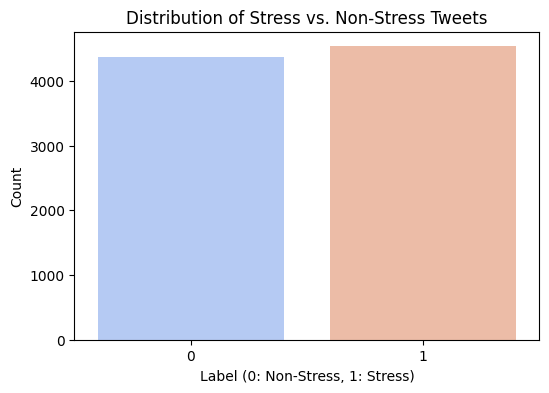

In [4]:
# Label distribution
plt.figure(figsize=(6,4))
sns.countplot(x=data['labels'], hue=data['labels'], palette='coolwarm', legend=False)
plt.title("Distribution of Stress vs. Non-Stress Tweets")
plt.xlabel("Label (0: Non-Stress, 1: Stress)")
plt.ylabel("Count")
plt.show()

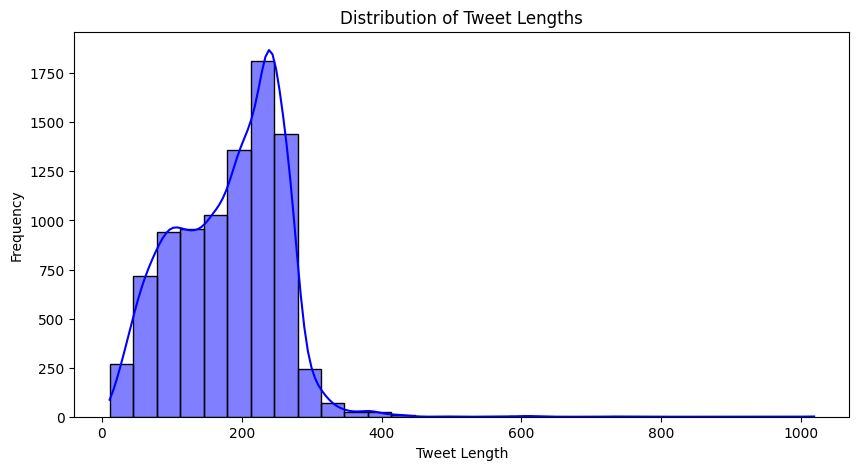

In [5]:
# Tweet Length Distribution
data['message_length'] = data['text'].apply(len)
plt.figure(figsize=(10,5))
sns.histplot(data['message_length'], bins=30, kde=True, color='blue')
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Lengths")
plt.show()

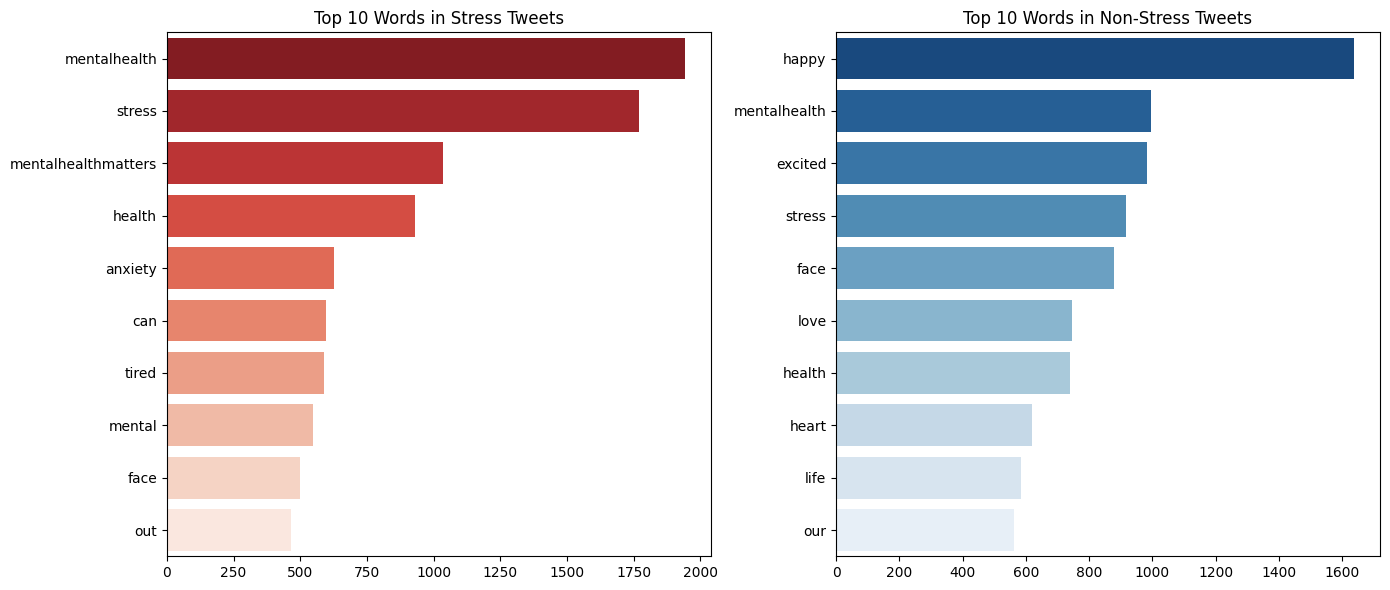

In [6]:
# Custom stopwords list
custom_stopwords = set(["i", "me", "my", "we", "you", "your", "he", "she", "it", "they", "is", "are", "was", "were", "be", "been", "have", "has", "had", "do", "does", "did", "a", "an", "the", "and", "or", "but", "if", "as", "with", "for", "of", "to", "in", "on", "at", "by", "about", "that", "this", "these", "those", "there", "when", "where", "how", "all", "any", "more", "most", "some", "such", "only", "own", "so", "than", "too", "very"])

def preprocess_text(text):
    text = text.lower().translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in custom_stopwords]  # Remove stopwords
    return words

data["processed_message"] = data["text"].apply(preprocess_text)
# Most common words
stress_words = Counter([word for words in data[data['labels'] == 1]['processed_message'] for word in words])
non_stress_words = Counter([word for words in data[data['labels'] == 0]['processed_message'] for word in words])

# Plot top 10 words
stress_common = dict(stress_words.most_common(10))
non_stress_common = dict(non_stress_words.most_common(10))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=list(stress_common.values()), y=list(stress_common.keys()), ax=ax[0], hue=list(stress_common.keys()), palette='Reds_r', legend=False)
ax[0].set_title("Top 10 Words in Stress Tweets")
sns.barplot(x=list(non_stress_common.values()), y=list(non_stress_common.keys()), ax=ax[1], hue=list(non_stress_common.keys()), palette='Blues_r', legend=False)
ax[1].set_title("Top 10 Words in Non-Stress Tweets")
plt.tight_layout()
plt.show()

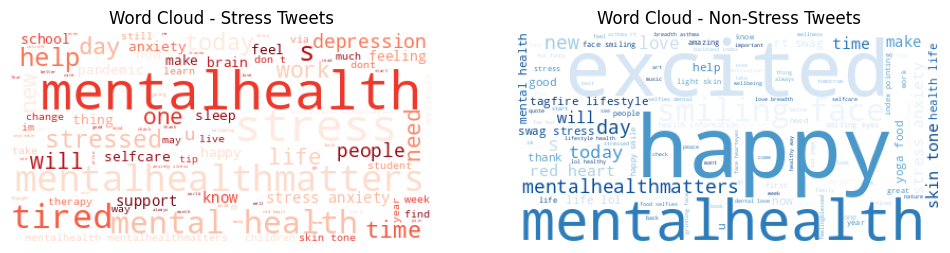

In [7]:
# Generate Word Clouds
stress_text = ' '.join([' '.join(words) for words in data[data['labels'] == 1]['processed_message']])
non_stress_text = ' '.join([' '.join(words) for words in data[data['labels'] == 0]['processed_message']])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(background_color='white', colormap='Reds').generate(stress_text))
plt.axis("off")
plt.title("Word Cloud - Stress Tweets")

plt.subplot(1,2,2)
plt.imshow(WordCloud(background_color='white', colormap='Blues').generate(non_stress_text))
plt.axis("off")
plt.title("Word Cloud - Non-Stress Tweets")
plt.show()

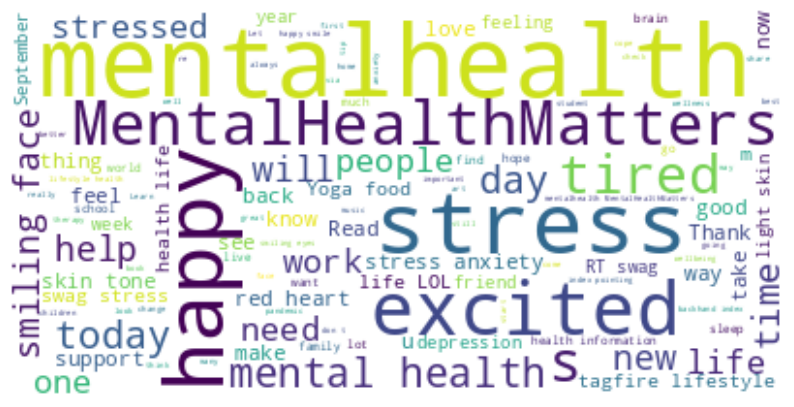

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(i for i in data.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white").generate(text)
plt.figure( figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
#3. Random Forest (Best Performing Model)
import nltk
import re
import string
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stopword = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def clean(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = " ".join([stemmer.stem(word) for word in text.split() if word not in stopword])
    return text
data["text"] = data["text"].apply(clean)
data["labels"] = data["labels"].map({0: "No Stress", 1: "Stress"})

'''# Shuffle dataset properly
data = data.sample(frac=1, random_state=42).reset_index(drop=True)'''

# Convert Text to Numerical Data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data["text"]).toarray()
y = data["labels"].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

'''# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)'''

# Optimized Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Evaluation Metrics
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Random Forest Accuracy: 0.8353932584269663
Classification Report:
               precision    recall  f1-score   support

   No Stress       0.90      0.74      0.82       873
      Stress       0.79      0.92      0.85       907

    accuracy                           0.84      1780
   macro avg       0.85      0.83      0.83      1780
weighted avg       0.85      0.84      0.83      1780



In [10]:
data = data[["text", "labels"]]
print(data.head())

                                                text     labels
0  mom clean shit end result everyth mess momlif ...     Stress
1  given walkthru book base whole school pd grin ...  No Stress
2  wish peac joy love joytrain mentalhealth quot ...  No Stress
3  speaknoevil monkey honest globe show europeafr...     Stress
4  psi u hv regret psi happi yes feel reliev good...  No Stress


In [11]:
# Shuffle dataset properly
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert Text to Numerical Data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data["text"]).toarray()
y = data["labels"].values

In [12]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
#1. Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train the model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluate
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.848314606741573
              precision    recall  f1-score   support

   No Stress       0.88      0.80      0.84       873
      Stress       0.82      0.89      0.86       907

    accuracy                           0.85      1780
   macro avg       0.85      0.85      0.85      1780
weighted avg       0.85      0.85      0.85      1780



In [14]:
#2. Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.7792134831460674
              precision    recall  f1-score   support

   No Stress       0.76      0.79      0.78       873
      Stress       0.79      0.76      0.78       907

    accuracy                           0.78      1780
   macro avg       0.78      0.78      0.78      1780
weighted avg       0.78      0.78      0.78      1780



In [15]:
# Predict new text
new_text = ["I'm feeling Happy"]
new_text_clean = [clean(t) for t in new_text]
new_text_vectorized = vectorizer.transform(new_text_clean).toarray()

# Predict stress level
prediction = rf_model.predict(new_text_vectorized)
print("Predicted Stress Level:", "Stress" if prediction[0] == "Stress" else "No Stress")

Predicted Stress Level: No Stress


In [16]:
# Predict new text
new_text = ["I'm feeling DEPRESSED"]
new_text_clean = [clean(t) for t in new_text]
new_text_vectorized = vectorizer.transform(new_text_clean).toarray()

# Predict stress level
prediction = rf_model.predict(new_text_vectorized)
print("Predicted Stress Level:", "Stress" if prediction[0] == "Stress" else "No Stress")

Predicted Stress Level: Stress


In [17]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{'No Stress': np.int64(3493), 'Stress': np.int64(3627)}


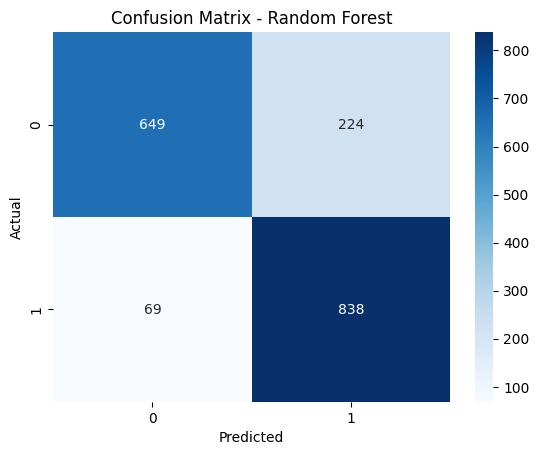

In [18]:
# Evaluate Model Performance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [19]:
#Save the Model
import joblib

# Save model
joblib.dump(rf_model, 'stress_model.pkl')

# Save vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [20]:
# Load saved model
rf_model = joblib.load('stress_model.pkl')
vectorizer1 = joblib.load('vectorizer.pkl')

# Predict new text
new_text = ["I'm feeling happy"]
new_text_clean = [clean(t) for t in new_text]
new_text_vectorized = vectorizer1.transform(new_text_clean).toarray()

# Predict sentiment (0 = Positive, 1 = Negative)
prediction = rf_model.predict(new_text_vectorized)
print("Predicted Sentiment:", "Negative" if prediction[0] == "Stress" else "Positive")

Predicted Sentiment: Positive


In [21]:
# Predict new text
new_text = ["I'm feeling DEPRESSED"]
new_text_clean = [clean(t) for t in new_text]
new_text_vectorized = vectorizer.transform(new_text_clean).toarray()

# Predict sentiment (0 = Positive, 1 = Negative)
prediction = rf_model.predict(new_text_vectorized)
print("Predicted Sentiment:", "Negative" if prediction[0] == "Stress" else "Positive")

Predicted Sentiment: Negative


In [22]:
!pip install streamlit==1.41.1 pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.1 MB/s eta 0:00:00


In [ ]:
!ngrok config add-authtoken [authtoken]

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
'''
app3.py
import streamlit as st
import joblib
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Load model and vectorizer
rf_model = joblib.load('stress_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

# Text preprocessing function
def clean(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    stemmer = PorterStemmer()
    stopword = set(stopwords.words('english'))
    text = " ".join([stemmer.stem(word) for word in text.split() if word not in stopword])
    return text

# Streamlit App
st.set_page_config(page_title="Stress Detection App", page_icon=":stress:", layout="centered")

# Title and description
st.title("🌟 Stress Detection App 🌟")
st.markdown(
    """
    This app analyzes the entered text to predict whether it indicates stress. Just type your text, click 'Predict,' and find out!

    ### How does it work?
    - The app uses a machine learning model trained on stress-related text.
    - It preprocesses your input by removing unwanted characters, stemming words, and filtering out stopwords.
    - Then it predicts whether the text indicates stress or not.
    """
)

# User input
user_input = st.text_area("Type your text here:", height=200)

# Add an interactive element for prediction
if st.button("Predict"):
    if user_input.strip() == "":
        st.warning("Please enter some text to analyze.")
    else:
        # Display progress bar during processing
        with st.spinner("Processing your text... Please wait."):
            cleaned_text = clean(user_input)
            vectorized_text = vectorizer.transform([cleaned_text]).toarray()
            prediction = rf_model.predict(vectorized_text)

            # Display prediction result
            result = "Stress" if prediction[0] == "Stress" else "No Stress"
            st.success(f"✅ **Predicted Stress Level:** {result}")

            # Additional feedback and tips
            if result == "Stress":
                st.warning("It seems like you're stressed! Take a break and relax.")
            else:
                st.info("You're doing well! Keep up the good work.")

# Footer with contact or additional information
st.markdown(
    """
    ---
    If you have any questions, feel free to contact us at: **support@stressdetect.com**
    """
)
'''

In [ ]:
from pyngrok import ngrok

# Define the new port for the Streamlit app
new_port = 8507

# Run the Streamlit app on the new port
!streamlit run app3.py --server.port {new_port} &>/content/logs.txt &

# Ensure all previous tunnels are closed before opening a new one
ngrok.kill()

# Start a new ngrok tunnel on the new port
public_url = ngrok.connect(new_port, "http")
print(f"Public URL: {public_url}")


Public URL: NgrokTunnel: "https://90c9-35-229-91-142.ngrok-free.app" -> "http://localhost:8507"


In [ ]:
# Ensure all previous tunnels are closed before opening a new one
ngrok.kill()

In [ ]:
!pip install gensim pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.6 MB/s eta 0:00:00


In [ ]:
# 2. Topic Modeling with LDA (Optional)
# -------------------
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare data for LDA
tokenized_data = [text.split() for text in data["text"]]
dictionary = corpora.Dictionary(tokenized_data)
corpus = [dictionary.doc2bow(text) for text in tokenized_data]
# LDA Model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=15)
lda_model.print_topics()

[(0,
  '0.029*"mentalhealth" + 0.021*"mentalhealthmatt" + 0.019*"health" + 0.014*"mental" + 0.010*"stress" + 0.007*"need" + 0.007*"new" + 0.007*"support" + 0.007*"help" + 0.006*"excit"'),
 (1,
  '0.048*"happi" + 0.033*"face" + 0.026*"heart" + 0.021*"smile" + 0.019*"love" + 0.008*"beauti" + 0.007*"motiv" + 0.007*"red" + 0.007*"life" + 0.007*"eye"'),
 (2,
  '0.059*"stress" + 0.025*"mentalhealth" + 0.016*"anxieti" + 0.011*"mind" + 0.010*"depress" + 0.008*"help" + 0.007*"health" + 0.007*"well" + 0.006*"point" + 0.006*"medit"'),
 (3,
  '0.023*"stress" + 0.020*"health" + 0.018*"anxieti" + 0.018*"food" + 0.017*"life" + 0.016*"lifestyl" + 0.016*"lol" + 0.015*"happi" + 0.015*"yoga" + 0.015*"love"'),
 (4,
  '0.018*"tire" + 0.016*"excit" + 0.010*"tone" + 0.009*"skin" + 0.009*"day" + 0.008*"get" + 0.008*"mentalhealth" + 0.008*"hand" + 0.006*"sleep" + 0.006*"go"')]

In [ ]:
# Visualization using pyLDAvis
pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)